In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#we need to read the file
#../input_data/trajNaCl.pdb
#500 timeframes

#bash command to filter
#grep ATOM trajNaCl.pdb | tr -s ' ' | cut -d' ' -f6-8 > filter_trajNaCl.txt

In [15]:
def data_init():
    data = np.loadtxt("../input_data/filter_trajNaCl.txt") #500 blocks of 40 lines
    cell = 31.47
    bins = 10 #total number of bins
    ngr = 0 # what is ngr for ?
    delg = cell/(2*bins) #delg is bin size... ?
    g = np.zeros(bins) 
    #First chunk over
    npart = 40 #amount of particles
    return data, cell, bins, ngr, delg, g, npart

In [12]:
#I have to figure out how the periodic conditions are given, is box a vector or not?
def rdf(g, ngr, cell, data, delg, npart):
    for k in range(0, 500, npart): #k for the different timeframes
        ngr = ngr + 1 #should be the right place for ngr, it seems to count timeframes?
        #the actual pairing
        #do it seperately for Na-Na, Na-Cl, Cl-Cl? Seems all at once is the right way
        for i in range(k+0, k+npart-1):
            for j in range(k+1, k+npart):
                #distance between a particle pair
                r = data[i]-data[j]
                #implement periodic boundary conditions
                r = r - cell*np.round(r/cell)
                r = np.linalg.norm(r)
                #half-box check & contribution
                if r <= cell/2: #this needs to be true in all fields to proceed right?
                    l = int(r/delg) #ok so l has to be a scalar, but r is a vector and delg as well...
                    g[l] = g[l] + 2
    return g, ngr

In [19]:
def grdf(g, ngr, bins):
    rho = 1 #Density of water+NaCl or what?
    for i in range(0, bins):
        r = delg*(i+0.5) #what is this supposed to be?
        vol = ((i+1)**3  - i**3 )*delg**3 #why is this a volume and then its used in the 4/3 pi r^3 rho formula, weird
        nid = (4/3)*np.pi*vol*rho  #according to the description a density
        g[i] = g[i]/(ngr*npart*nid) #ngr is the pair number? npart?  
    return g

In [20]:
data, cell, bins, ngr, delg, g, npart = data_init()
g, ngr = rdf(g, ngr, cell, data, delg, npart)
g = grdf(g, ngr, bins)

IndexError: index 10 is out of bounds for axis 0 with size 10

(array([2., 2., 1., 1., 1., 0., 1., 1., 0., 1.]),
 array([  96. ,  640.6, 1185.2, 1729.8, 2274.4, 2819. , 3363.6, 3908.2,
        4452.8, 4997.4, 5542. ]),
 <BarContainer object of 10 artists>)

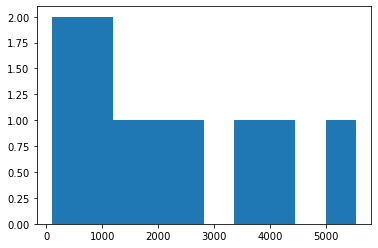

In [17]:
plt.hist(g, bins)